# Drought Analysis

## Request
Using NASA remote sensing data, prepare historical drought analysis for Syria and bordering countries. Estimate hectares of farmland where drought has occurred over the past 5 years. 

## Drought Index
There are several drought indices in the literature, the majority of them look a trends in rainfall and temperature to identify droughts at different time intervals. We use the [Standardised Precipitation-Evapotranspiration Index (SPEI)](https://spei.csic.es/home.html)  

### SPEI
The [SPEI](https://spei.csic.es) is an extension of the widely used Standardized Precipitation Index (SPI). The SPEI is designed to take into account both `precipitation` and `potential evapotranspiration` (PET) in determining drought. Thus, unlike the SPI, the SPEI captures the main impact of increased temperatures on water demand.  

The idea behind the SPEI is to compare the highest possible evapotranspiration (what we call the evaporative demand by the atmosphere) with the current water availability. Thus, precipitation (accumulated over a period of time) in the SPEI stands for the water availability, while ETo stands for the atmospheric water demand.  

### Time Scales
The SPEI can measure different types of drought (levels of severity and duration) depending on the time timescale factor. At the shortest time scales (3/6 months) the drought series show a high frequency of drought, and moist periods of short duration. In contrast, at the longest time scales (12/18 months) the drought periods are of longer duration and lower frequency.

### Interpretation

Negative SPEI values represent rainfall deficit and high potential epotranspiration (dry conditions), starting when the SPEI value is equal or below -1.0. Whereas positive SPEI values indicate rainfall surplus and low potential epotranspiration (wet conditions), starting when the SPEI value is equal or above 1.0.

## Maps of Monthly SPEI (6-month window)

Each row in this panel of maps is a year, and each column is a month. Red values signify dry conditions (drought), and blue values signify wet conditions.

![spei_drought_timeseries_maps.png](../../docs/images/agriculture/spei_drought_timeseries_maps.png)

In [1]:
import warnings
warnings.filterwarnings('ignore')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


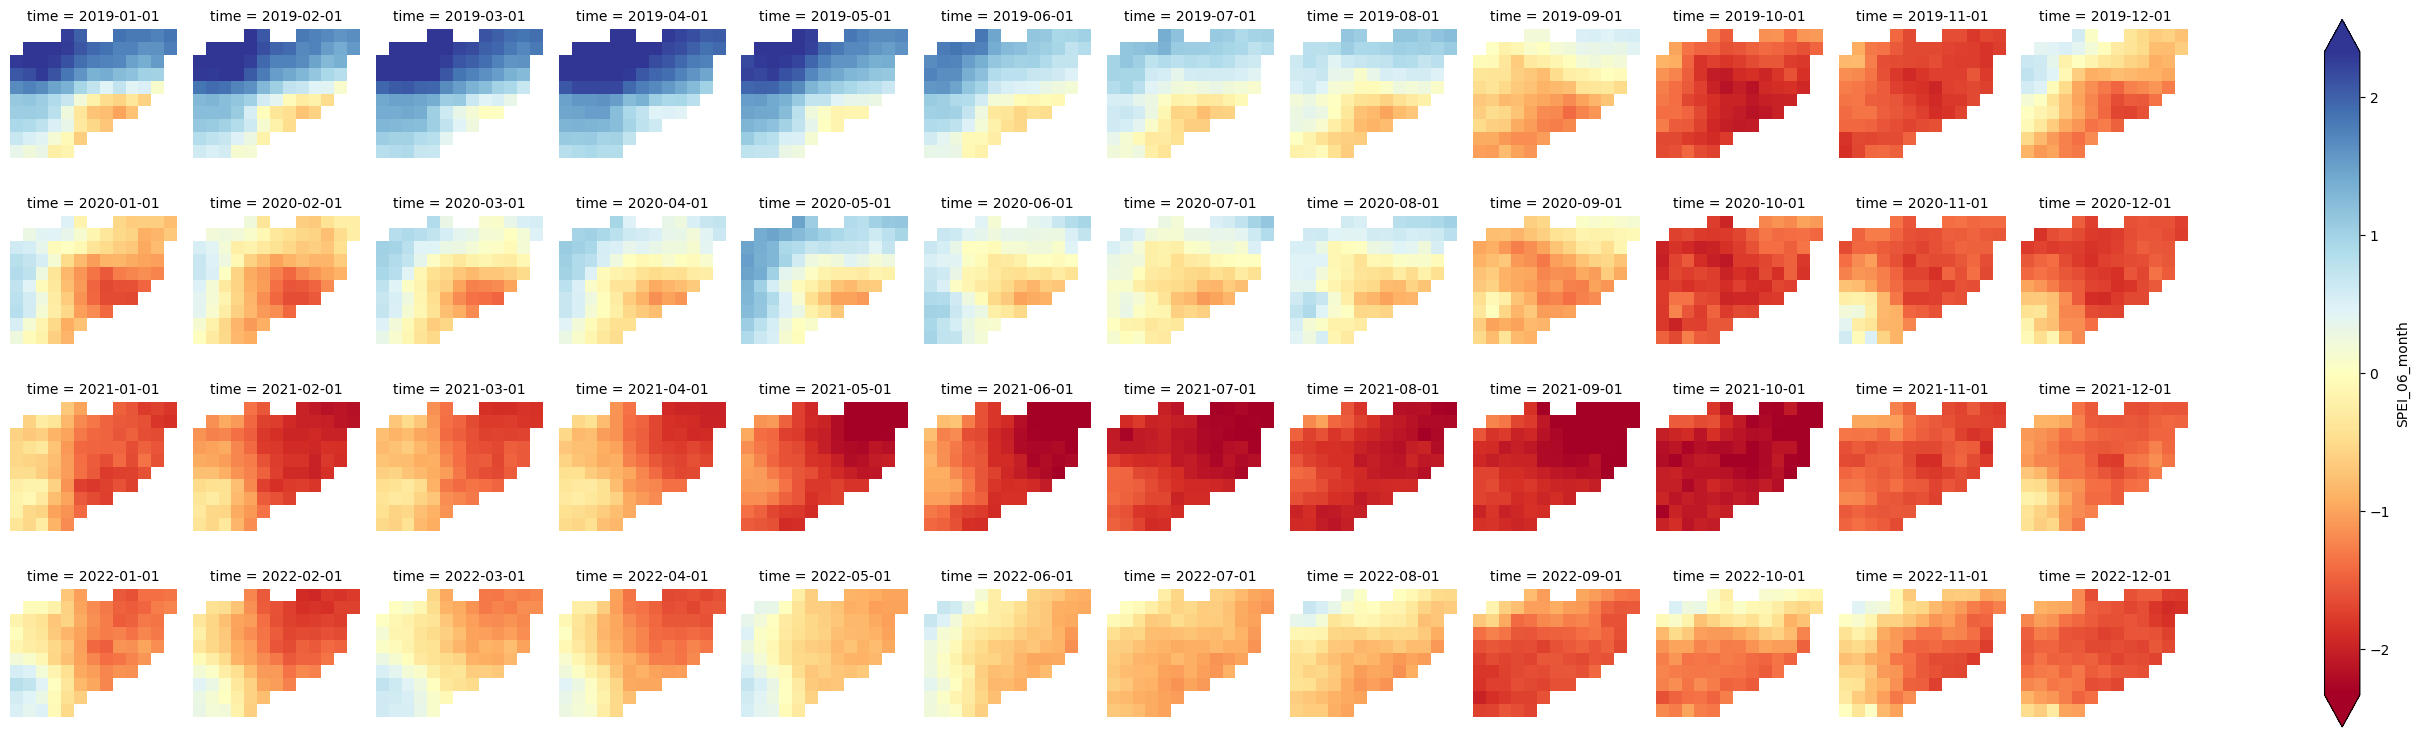

In [2]:
# Imports
import ee

ee.Initialize()
import requests
import geopandas as gpd
from geemap.conversion import *
import xarray as xr
import matplotlib.pyplot as plt

# Admin Data
adm = "ADM0"
iso3 = "SYR"
release_type = "gbOpen"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
try:
    res = requests.get(geo_url).json()
    adm0_syr = gpd.read_file(res["gjDownloadURL"])
    # adm0_ner.to_file('../../data/adm0_ner.geojson', driver='GeoJSON')
except:
    adm0_syr = gpd.read_file("../../data/adm0_syr.geojson")

one = adm0_syr.iloc[[0]]
centx, centy = one.centroid.x.iloc[0], one.centroid.y.iloc[0]
aoi = gdf_to_ee(adm0_syr)

spei = (
    ee.ImageCollection("CSIC/SPEI/2_9")
    .select("SPEI_06_month")
    .filterDate("2019-01-01", "2023-12-31")
)


def clip_image(image):
    return image.clip(aoi)


spei = spei.map(clip_image)

ds = xr.open_dataset(
    spei,
    engine="ee",
    geometry=aoi.geometry(),
    crs="EPSG:4326",
    scale=0.5,
)
ax = ds["SPEI_06_month"].plot.imshow(
    robust=True,
    x="lon",
    y="lat",
    cmap="RdYlBu",
    vmin=-2.33,
    vmax=2.33,
    col="time",
    col_wrap=12,
    figsize=(28, 8),
)  # figsize=(10, 10) aspect=2, size=10
ax.map(lambda: plt.axis("off"))
for a in ax.axs.flat:
    a.set_aspect("equal")

The Global SPEI Database only contains data up to 2022. The authors also provide less accurate but real-time data through the [SPEI Global Drought Monitor](https://spei.csic.es/map/maps.html#months=1#month=3#year=2024). In the maps below, we show the progression of SPEI for 2023 and 2024, using the coarser (1 degree resolution) real-time data.  

*An important difference between the data sources is that the SPEI Global Drought Monitor is based on the Thortnthwaite equation for estimating potential evapotranspiration, PET. This is due to the lack of real-time data sources for computing more robust PET estimations which have larger data requirements.*

In [3]:
base_path = "C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor"

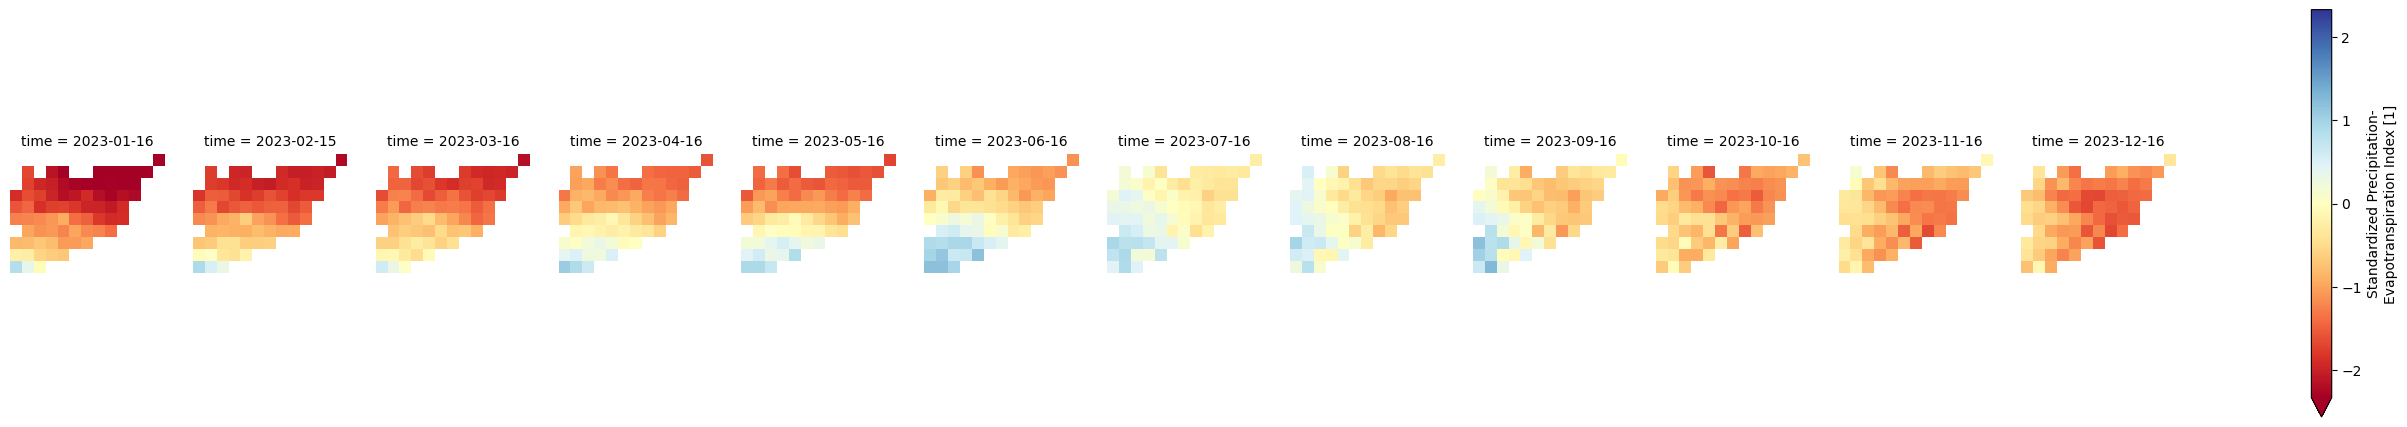

In [4]:
from os.path import join, expanduser

# Download from https://spei.csic.es/map/maps.html
spei_data_path = os.path.join(base_path,'data','spei06.nc')
ds2 = xr.open_dataset(spei_data_path)
ds2 = ds2.isel(lat=slice(None, None, -1))
# slice time dimension
ds2 = ds2.sel(time=slice("2023-01-01", "2024-12-31"))
ds2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds2.rio.write_crs("EPSG:4326", inplace=True)
clipped = ds2.rio.clip(adm0_syr.geometry.values, adm0_syr.crs, drop=True, invert=False)
ax = clipped["spei"].plot(
    robust=True,
    x="lon",
    y="lat",
    cmap="RdYlBu",
    vmin=-2.33,
    vmax=2.33,
    col="time",
    col_wrap=12,
    figsize=(28, 5),
)  # figsize=(10, 10) aspect=2, size=10
ax.map(lambda: plt.axis("off"))
for a in ax.axs.flat:
    a.set_aspect("equal")

## Trend of SPEI (6-month) in Syria

The chart below shows the historical trend in SPEI 6-month from 2016 to 2023 using the median value.

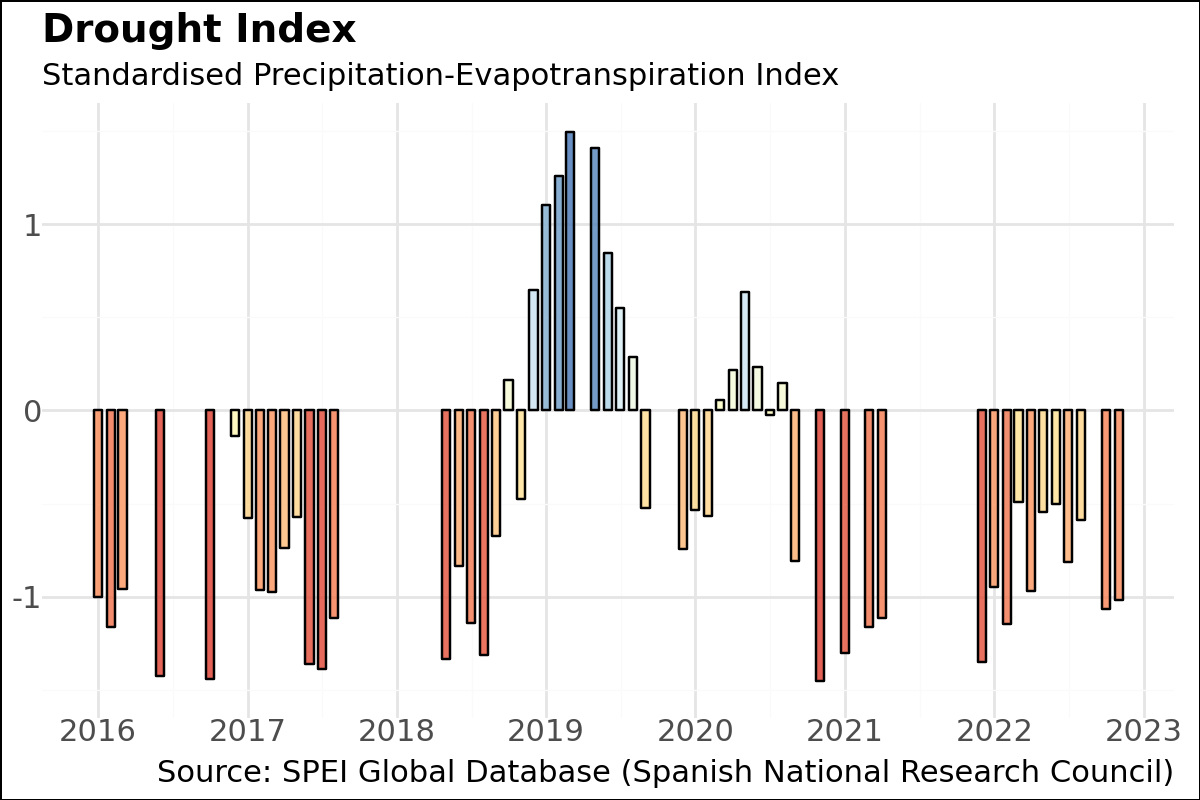

In [5]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

spei = (
    ee.ImageCollection("CSIC/SPEI/2_9")
    .select("SPEI_06_month")
    .filterDate("2016-01-01", "2023-12-31")
)


def clip_image(image):
    return image.clip(aoi)


spei = spei.map(clip_image)

ds = xr.open_dataset(
    spei,
    engine="ee",
    geometry=aoi.geometry(),
    crs="EPSG:4326",
    scale=0.5,
)

country_median = ds.median(dim=["lat", "lon"])
df = country_median["SPEI_06_month"].to_dataframe().reset_index()
df.loc[:, "ymd"] = df["time"].dt.strftime("%Y-%m-%d")
df.loc[:, "group"] = 1

font = "Roboto"
p = (
    ggplot(df, aes(x="ymd", y="SPEI_06_month", group="group", fill="SPEI_06_month"))
    + geom_bar(alpha=0.8, stat="identity", color="black", width=20)
    + labs(
        x="",
        subtitle="Standardised Precipitation-Evapotranspiration Index",
        title="Drought Index",
        y="",
        caption="Source: SPEI Global Database (Spanish National Research Council)",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(6, 4),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        legend_position="none",
    )
    + scale_fill_distiller(
        type="div", palette="RdYlBu", direction=1, limits=(-1.5, 1.5)
    )
    + scale_y_continuous(limits=(-1.5, 1.5))
    + scale_x_datetime(
        breaks=date_breaks("1 year"), labels=date_format("%Y")
    )  # 6 month "%b, %y"
)
p

## Trend of SPEI (12-month) in Syria

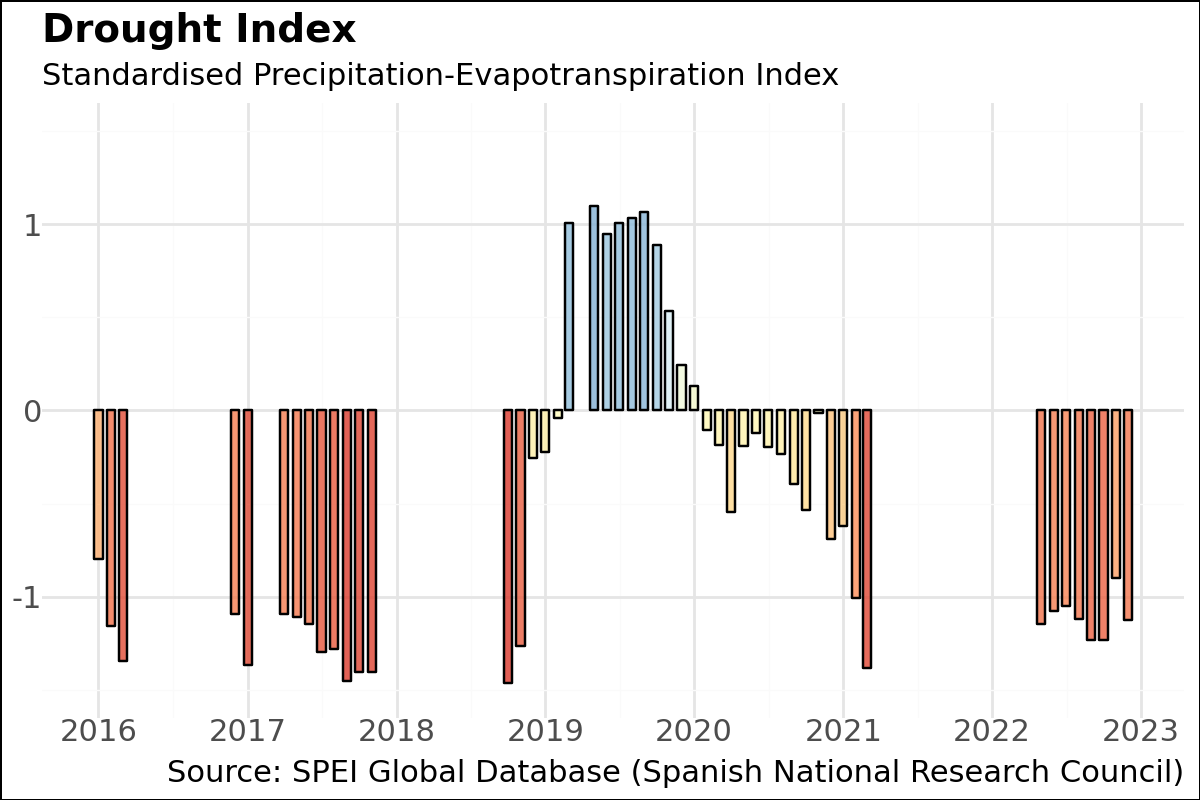

In [6]:
spei = (
    ee.ImageCollection("CSIC/SPEI/2_9")
    .select("SPEI_12_month")
    .filterDate("2016-01-01", "2023-12-31")
)


def clip_image(image):
    return image.clip(aoi)


spei = spei.map(clip_image)

ds = xr.open_dataset(
    spei,
    engine="ee",
    geometry=aoi.geometry(),
    crs="EPSG:4326",
    scale=0.5,
)

country_median = ds.median(dim=["lat", "lon"])
df = country_median["SPEI_12_month"].to_dataframe().reset_index()
df.loc[:, "ymd"] = df["time"].dt.strftime("%Y-%m-%d")
df.loc[:, "group"] = 1

font = "Roboto"
p = (
    ggplot(df, aes(x="ymd", y="SPEI_12_month", group="group", fill="SPEI_12_month"))
    + geom_bar(alpha=0.8, stat="identity", color="black", width=20)
    + labs(
        x="",
        subtitle="Standardised Precipitation-Evapotranspiration Index",
        title="Drought Index",
        y="",
        caption="Source: SPEI Global Database (Spanish National Research Council)",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(6, 4),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        legend_position="none",
    )
    + scale_fill_distiller(
        type="div", palette="RdYlBu", direction=1, limits=(-1.5, 1.5)
    )
    + scale_y_continuous(limits=(-1.5, 1.5))
    + scale_x_datetime(
        breaks=date_breaks("1 year"), labels=date_format("%Y")
    )  # 6 month "%b, %y"
)
p

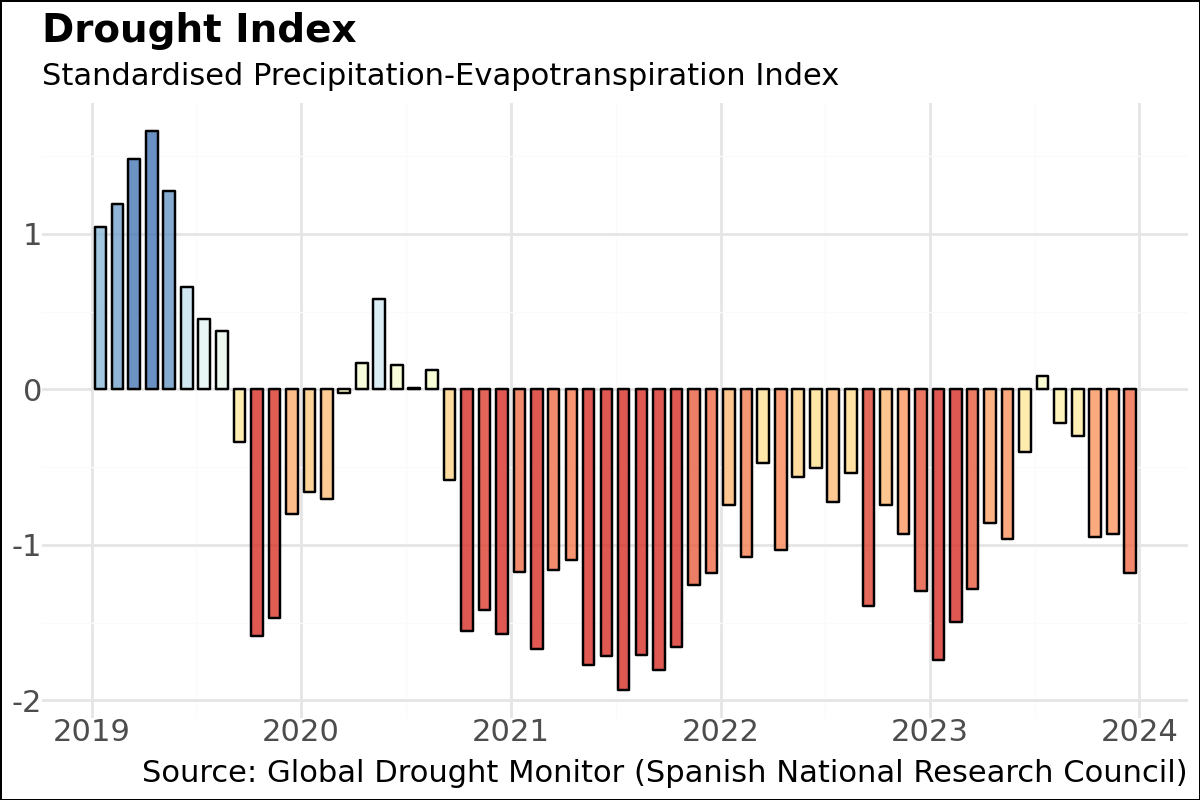

In [7]:
# pal = colormaps.get_palette('RdYlBu', 10) # Greens BrBG
# visParams = {
#   'min': -2.33,
#   'max':  2.33,
#   'palette': pal
# }

# spei = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").select('spei').filterDate('2019-01-01', '2023-12-31')
# one = spei.first().clip(aoi)


# m = Map(center=[centy, centx], zoom=6) # basemap='Esri.WorldImagery'
# m.addLayer(one, visParams, 'SPEI')
# # m.add_time_slider(spei, visParams, time_interval=1)
# m.addLayerControl()
# m

# Download from https://spei.csic.es/map/maps.html
ds2 = xr.open_dataset(spei_data_path)
ds2 = ds2.isel(lat=slice(None, None, -1))
# slice time dimension
ds2 = ds2.sel(time=slice("2019-01-01", "2023-12-31"))
ds2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds2.rio.write_crs("EPSG:4326", inplace=True)
clipped = ds2.rio.clip(adm0_syr.geometry.values, adm0_syr.crs, drop=True, invert=False)

country_median = clipped.median(dim=["lat", "lon"])
df = country_median["spei"].to_dataframe().reset_index()
df.loc[:, "ymd"] = df["time"].dt.strftime("%Y-%m-%d")
df.loc[:, "group"] = 1

font = "Roboto"
p = (
    ggplot(df, aes(x="ymd", y="spei", group="group", fill="spei"))
    + geom_bar(alpha=0.8, stat="identity", color="black", width=20)
    + labs(
        x="",
        subtitle="Standardised Precipitation-Evapotranspiration Index",
        title="Drought Index",
        y="",
        caption="Source: Global Drought Monitor (Spanish National Research Council)",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(6, 4),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        legend_position="none",
    )
    + scale_fill_distiller(
        type="div", palette="RdYlBu", direction=1, limits=(-1.5, 1.5)
    )
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
)
p

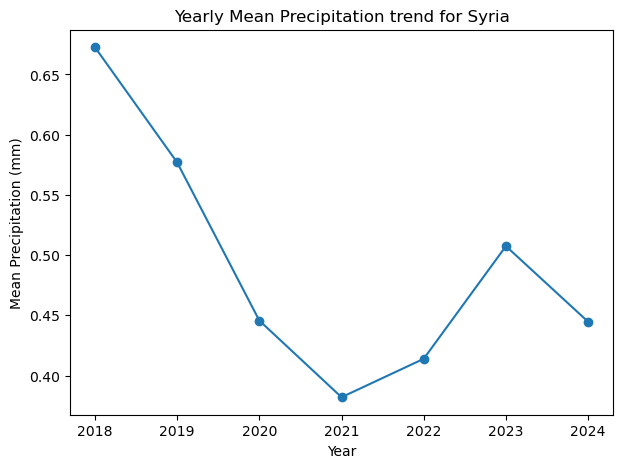

In [4]:
# Load CHIRPS dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")

# Filter dataset to the region of Sudan and select precipitation values from 2000 to 2024
sudan_chirps = chirps.filterBounds(aoi).filterDate('2018-01-01', '2024-08-31')

# Calculate yearly mean precipitation
def calculate_yearly_mean(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')
    yearly_data = sudan_chirps.filterDate(start_date, end_date)
    return yearly_data.mean().set('year', year)

# Generate list of yearly mean images
years = list(range(2018, 2025))
yearly_precip = [calculate_yearly_mean(year) for year in years]

# Create an ImageCollection from the yearly mean images
yearly_precip_collection = ee.ImageCollection.fromImages(yearly_precip)

# Extract precipitation values to a list
mean_precipitation = []
for year in years:
    image = yearly_precip_collection.filter(ee.Filter.eq('year', year)).first()
    mean_value = image.reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=aoi,
        scale=5000,
        maxPixels=1e9
    ).get('precipitation').getInfo()
    mean_precipitation.append(mean_value)

# Plotting the mean precipitation values over years
plt.figure(figsize=(7, 5))
plt.plot(years, mean_precipitation, marker='o')
plt.xlabel("Year")
plt.ylabel("Mean Precipitation (mm)")
plt.title("Yearly Mean Precipitation trend for Syria")
plt.grid(False)
plt.show()


![Yearly_mean_precipitation_trend_2010_2014.png](../../docs/images/agriculture/yearly_mean_pp_2010_2024.png)

### Monthly Rainfall Trends

::::{tab-set}
:::{tab-item} 2019
![Monthly_rainfall_2019.png](../../docs/images/agriculture/Monthly_rainfall_2019.png)
:::
:::{tab-item} 2020
![Monthly_rainfall_2024.png](../../docs/images/agriculture/Monthly_rainfall_2020.png)
:::
:::{tab-item} 2021
![Monthly_rainfall_2023.png](../../docs/images/agriculture/Monthly_rainfall_2021.png)
:::
:::{tab-item} 2022
![Monthly_rainfall_2024.png](../../docs/images/agriculture/Monthly_rainfall_2022.png)
:::
:::{tab-item} 2023
![Monthly_rainfall_2023.png](../../docs/images/agriculture/Monthly_rainfall_2023.png)
:::
:::{tab-item} 2024
![Monthly_rainfall_2024.png](../../docs/images/agriculture/Monthly_rainfall_2024_2.png)
:::
::::

In [9]:
import ee
import geopandas as gpd
import json
from geemap import geojson_to_ee
import geemap.chart as chart

# Initialize the Earth Engine API
#ee.Initialize()

# Load the Syria boundary shapefile using geopandas
shapefile_path = os.path.join(base_path,'data','boundaries','syr_admin1.shp')  # Update with the actual path
gdf = gpd.read_file(shapefile_path)

# Convert the GeoDataFrame to GeoJSON and parse it into a dictionary
geojson = json.loads(gdf.to_json())

# Convert GeoJSON to an Earth Engine FeatureCollection
syria_boundary = geojson_to_ee(geojson)

# Define the CHIRPS dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")

# Define the year of interest
year = 2022
start_date = ee.Date.fromYMD(year, 1, 1)
end_date = start_date.advance(1, 'year')

# Filter the CHIRPS dataset for the year of interest
year_filtered = chirps.filter(ee.Filter.date(start_date, end_date))

# Create a list of months
months = ee.List.sequence(1, 12)

# Function to calculate monthly rainfall
def create_monthly_image(month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    month_filtered = year_filtered.filter(ee.Filter.date(start_date, end_date))
    total = month_filtered.reduce(ee.Reducer.sum())
    return total.set({
        'system:time_start': start_date.millis(),
        'system:time_end': end_date.millis(),
        'year': year,
        'month': month
    })

# Map the function over the list of months
monthly_images = months.map(create_monthly_image)
monthly_collection = ee.ImageCollection.fromImages(monthly_images)

# Create a chart of monthly rainfall for the Syria boundary
rainfall_chart = chart.image_series(
    image_collection=monthly_collection,
    region=syria_boundary.geometry(),
    reducer=ee.Reducer.mean(),
    scale=5000,
    title='Monthly Rainfall in Syria (2022)',
    x_axis_label='Month',
    y_axis_label='Rainfall (mm)',
    line_width=2,
    point_size=4,
)

rainfall_chart


In [10]:
import ee
import geopandas as gpd
import json
from geemap import geojson_to_ee
import geemap.chart as chart

# Initialize the Earth Engine API
#ee.Initialize()

# Load the Syria boundary shapefile using geopandas
shapefile_path = os.path.join(base_path,'data','boundaries','syr_admin1.shp')  # Update with the actual path
gdf = gpd.read_file(shapefile_path)

# Convert the GeoDataFrame to GeoJSON and parse it into a dictionary
geojson = json.loads(gdf.to_json())

# Convert GeoJSON to an Earth Engine FeatureCollection
syria_boundary = geojson_to_ee(geojson)

# Define the CHIRPS dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")

# Define the year of interest
year = 2020
start_date = ee.Date.fromYMD(year, 1, 1)
end_date = start_date.advance(1, 'year')

# Filter the CHIRPS dataset for the year of interest
year_filtered = chirps.filter(ee.Filter.date(start_date, end_date))

# Create a list of months
months = ee.List.sequence(1, 12)

# Function to calculate monthly rainfall
def create_monthly_image(month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    month_filtered = year_filtered.filter(ee.Filter.date(start_date, end_date))
    total = month_filtered.reduce(ee.Reducer.sum())
    return total.set({
        'system:time_start': start_date.millis(),
        'system:time_end': end_date.millis(),
        'year': year,
        'month': month
    })

# Map the function over the list of months
monthly_images = months.map(create_monthly_image)
monthly_collection = ee.ImageCollection.fromImages(monthly_images)

# Create a chart of monthly rainfall for the Syria boundary
rainfall_chart = chart.image_series(
    image_collection=monthly_collection,
    region=syria_boundary.geometry(),
    reducer=ee.Reducer.mean(),
    scale=5000,
    title='Monthly Rainfall in Syria (2020)',
    x_axis_label='Month',
    y_axis_label='Rainfall (mm)',
    line_width=2,
    point_size=4,
)

rainfall_chart


In [11]:
import ee
import geopandas as gpd
import json
from geemap import geojson_to_ee
import geemap.chart as chart
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Load the Syria boundary shapefile using geopandas
shapefile_path = os.path.join(base_path,'data','boundaries','syr_admin1.shp')  # Update with the actual path
gdf = gpd.read_file(shapefile_path)

# Convert the GeoDataFrame to GeoJSON and parse it into a dictionary
geojson = json.loads(gdf.to_json())

# Convert GeoJSON to an Earth Engine FeatureCollection
syria_boundary = geojson_to_ee(geojson)

# Define the CHIRPS dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")

# Define the range of years
start_year = 2019
end_year = 2023

# Initialize an empty list to store monthly images for all years
all_monthly_images = ee.List([])

#Function to calculate monthly rainfall
def create_monthly_image(month):
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')
        month_filtered = year_filtered.filter(ee.Filter.date(start_date, end_date))
        total = month_filtered.reduce(ee.Reducer.sum())
        return total.set({
            'system:time_start': start_date.millis(),
            'system:time_end': end_date.millis(),
            'year': year,
            'month': month
        })

# Loop through each year and aggregate monthly rainfall
for year in range(start_year, end_year + 1):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year + 1, 1, 1)
    
    # Filter the CHIRPS dataset for the year
    year_filtered = chirps.filter(ee.Filter.date(start_date, end_date))
    
    # Create a list of months
    months = ee.List.sequence(1, 12)
    
 
    monthly_images = months.map(create_monthly_image)
    print(monthly_images.size().getInfo())
    #monthly_collection = ee.ImageCollection.fromImages(monthly_images)

    # Combine images into the all_monthly_images list
    all_monthly_images = all_monthly_images.add(monthly_images)

all_monthly_images = all_monthly_images.flatten()
#print(all_monthly_images.size().getInfo())
    

# Combine all monthly images into a single ImageCollection
all_monthly_collection = ee.ImageCollection.fromImages((all_monthly_images))

# Create a chart of monthly rainfall for the Syria boundary
rainfall_chart = chart.image_series(
    image_collection=all_monthly_collection,
    region=syria_boundary.geometry(),
    reducer=ee.Reducer.mean(),
    scale=5000,
    title='Monthly Rainfall in Syria (2019-2024)',
    x_axis_label='Time',
    y_axis_label='Rainfall (mm)',
    line_width=2,
    point_size=4,
)

rainfall_chart

#all_monthly_images

12
12
12
12
12


In [12]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from geemap import geojson_to_ee

# Initialize the Earth Engine API
ee.Initialize()

# Define the CHIRPS dataset and Syria boundary
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")

# Load the Syria boundary shapefile
syria_boundary = geojson_to_ee(json.loads(gdf.to_json()))

# Define the range of years
start_year = 2019
end_year = 2023

# Initialize a list to store monthly data
data_list = []

# Function to calculate monthly rainfall
def create_monthly_image(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    monthly_image = chirps.filter(ee.Filter.date(start_date, end_date)).reduce(ee.Reducer.sum())
    mean_rainfall = monthly_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=syria_boundary.geometry(),
        scale=5000
    ).get('precipitation')
    return {
        'year': year,
        'month': month,
        'mean_rainfall': mean_rainfall
    }

# Loop through each year and month to aggregate rainfall data
for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        result = create_monthly_image(year, month)
        data_list.append(result)

# Convert the data into a DataFrame
data = pd.DataFrame(data_list)
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

'''# Retrieve values from Earth Engine
def fetch_value(row):
    return ee.Number(row['mean_rainfall']).getInfo()

data['rainfall'] = data.apply(fetch_value, axis=1)

# Plot the data using Plotly
fig = px.line(
    data,
    x='date',
    y='rainfall',
    title='Monthly Rainfall in Syria (2019-2024)',
    labels={'rainfall': 'Rainfall (mm)', 'date': 'Time'},
    template='plotly_white'
)

# Add a range slider for interactivity
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    )
)

# Show the interactive plot
fig.show()'''

print(data)


    year  month                                      mean_rainfall       date
0   2019      1  ee.ComputedObject({\n  "functionInvocationValu... 2019-01-01
1   2019      2  ee.ComputedObject({\n  "functionInvocationValu... 2019-02-01
2   2019      3  ee.ComputedObject({\n  "functionInvocationValu... 2019-03-01
3   2019      4  ee.ComputedObject({\n  "functionInvocationValu... 2019-04-01
4   2019      5  ee.ComputedObject({\n  "functionInvocationValu... 2019-05-01
5   2019      6  ee.ComputedObject({\n  "functionInvocationValu... 2019-06-01
6   2019      7  ee.ComputedObject({\n  "functionInvocationValu... 2019-07-01
7   2019      8  ee.ComputedObject({\n  "functionInvocationValu... 2019-08-01
8   2019      9  ee.ComputedObject({\n  "functionInvocationValu... 2019-09-01
9   2019     10  ee.ComputedObject({\n  "functionInvocationValu... 2019-10-01
10  2019     11  ee.ComputedObject({\n  "functionInvocationValu... 2019-11-01
11  2019     12  ee.ComputedObject({\n  "functionInvocationValu.

In [13]:
import ee
import geopandas as gpd
import json
from geemap import geojson_to_ee
import geemap.chart as chart
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Load the Syria boundary shapefile using geopandas
#shapefile_path = "path_to_your_syria_shapefile.shp"  # Update with the actual path
shapefile_path = os.path.join(base_path,'data','boundaries','syr_admin1.shp')
gdf = gpd.read_file(shapefile_path)

# Convert the GeoDataFrame to GeoJSON and parse it into a dictionary
geojson = json.loads(gdf.to_json())

# Convert GeoJSON to an Earth Engine FeatureCollection
syria_boundary = geojson_to_ee(geojson)

# Define the CHIRPS dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")

# Define the range of years
start_year = 2019
end_year = 2024

# Initialize an empty list to store monthly images for all years
all_monthly_images = []

# Loop through each year and aggregate monthly rainfall
for year in range(start_year, end_year + 1):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year + 1, 1, 1)
    
    # Filter the CHIRPS dataset for the year
    year_filtered = chirps.filter(ee.Filter.date(start_date, end_date))
    
    # Create a list of months
    months = ee.List.sequence(1, 12)
    
    # Function to calculate monthly rainfall
    def create_monthly_image(month):
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')
        month_filtered = year_filtered.filter(ee.Filter.date(start_date, end_date))
        total = month_filtered.reduce(ee.Reducer.sum())
        return total.set({
            'system:time_start': start_date.millis(),
            'system:time_end': end_date.millis(),
            'year': year,
            'month': month
        })
    
    # Map the function over the list of months
    monthly_images = months.map(create_monthly_image)

    all_monthly_images = all_monthly_images.append(monthly_images)
    

# Combine all monthly images into a single ImageCollection
all_monthly_collection = ee.ImageCollection.fromImages(all_monthly_images)

# Create a chart of monthly rainfall for the Syria boundary
rainfall_chart = chart.image_series(
    image_collection=all_monthly_collection,
    region=syria_boundary.geometry(),
    reducer=ee.Reducer.mean(),
    scale=5000,
    title='Monthly Rainfall in Syria (2019-2024)',
    x_axis_label='Time',
    y_axis_label='Rainfall (mm)',
    line_width=2,
    point_size=4,
)

rainfall_chart

AttributeError: 'NoneType' object has no attribute 'append'

In [ ]:
import geemap
# Define the boundary of Syria
syria_boundary = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
                    .filter(ee.Filter.eq('country_na', 'Syria'))

# Load the JRC Global Surface Water dataset (selecting the 'occurrence' band)
water_bodies = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence')

# Clip the water occurrence data to the Syria boundary
water_bodies_clipped = water_bodies.clip(aoi)

# Set visualization parameters for displaying the water occurrence data
vis_params = {
    'min': 0,
    'max': 100,
    'palette': ['white', 'blue']
}

# Create a map using geemap and display the water occurrence data
Map = geemap.Map(center=[35, 38], zoom=6)
Map.addLayer(syria_boundary, {}, 'Syria Boundary')
Map.addLayer(water_bodies_clipped, vis_params, 'Water Bodies Occurrence')
Map.addLayerControl()
Map


Map(center=[35, 38], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [ ]:
'''# Export the clipped water occurrence data to Google Drive
export_task = ee.batch.Export.image.toDrive(
    image=water_bodies_clipped,
    description='Syria_WaterBodies_Occurrence',
    scale=30,
    region=aoi,
    fileFormat='GeoTIFF'
)
export_task.start()'''

In [ ]:
water_bodies_syria_gdf

,GLWD_ID,TYPE,LAKE_NAME,DAM_NAME,POLY_SRC,AREA_SKM,PERIM_KM,LONG_DEG,LAT_DEG,ELEV_M,...,MGLD_AREA,LRS_AREA,LRS_AR_SRC,LRS_CATCH,DAM_HEIGHT,DAM_YEAR,USE_1,USE_2,USE_3,geometry
0,279,Reservoir,Assad,None,DCW,638.6,228.9,38.10,36.07,293,...,600,NaN,None,NaN,NaN,NaN,None,None,None,"POLYGON ((38.1875 36.35158, 38.1915 36.34816, ..."
1,1196,Lake,Tiberias,None,DCW,155.8,50.9,35.59,32.80,-202,...,150,NaN,None,NaN,NaN,NaN,None,None,None,"POLYGON ((35.64804 32.80998, 35.64448 32.81066..."


### Detecting Water Bodies in Syria 

::::{tab-set}
:::{tab-item} Assad reservoir
![water_buffer_zones.png](../../docs/images/agriculture/water_buffer_zones.png)
:::
::::

In [ ]:
#MODIS Data for EVI
start_period = ee.Date("2019-01-01")
end_period = ee.Date("2024-09-30")

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")

#----------------------BITWISE MASKING---------------------------------------
def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}

esa_worldcover = ee.ImageCollection("ESA/WorldCover/v100").mosaic()
crop_data1 = esa_worldcover.select("Map").eq(40).rename("crop")

scale_factor = 0.0001

# apply cropland mask to imageCollection
def cropmask(img):
    return img.updateMask(crop_data1).clip(aoi)  # .multiply(scale_factor) # unmask(-1)


mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)

In [ ]:
water_bodies = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence').clip(aoi)
water_bodies_masked = water_bodies.gt(50)

buffered_water_bodies = water_bodies.reduceToVectors(
    geometryType='polygon',
    reducer=ee.Reducer.countEvery(),
    scale=30,
    geometry=syria_boundary.geometry(),
    maxPixels=1e13
).geometry().buffer(1000).simplify(500)  # Buffer in meters (adjust as needed)


# Calculate mean EVI for each image in the collection near the buffered water bodies
evi_time_series = mxd13q1.map(lambda img: img.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=buffered_water_bodies,
    scale=500,
    bestEffort=True
).set('date', img.date().format('YYYY-MM-dd')))

# Convert the results to a feature collection for export
evi_features = evi_time_series.map(lambda dict_entry: ee.Feature(None, dict_entry))
evi_fc = ee.FeatureCollection(evi_features)

# Export the time series to Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=evi_fc,
    description='EVI_Time_Series_Near_Water_Bodies_Syria',
    fileFormat='CSV'
)
export_task.start()


print("Export task started. Check your Google Drive for the CSV file.")

Export task started. Check your Google Drive for the CSV file.


In [ ]:
'''# Calculate mean EVI over the time period
mean_evi = mxd13q1.mean().clip(buffered_water_bodies)

# Set visualization parameters for EVI
evi_vis_params = {
    'min': 0,
    'max': 8000,
    'palette': ['white', 'lightgreen', 'green', 'darkgreen']
}

# Create a map using geemap and display the mean EVI near water bodies
Map = geemap.Map(center=[35, 38], zoom=6)
Map.addLayer(syria_boundary, {}, 'Syria Boundary')
Map.addLayer(buffered_water_bodies, {'color': 'blue'}, 'Buffered Water Bodies')
Map.addLayer(mean_evi, evi_vis_params, 'Mean EVI Near Water Bodies')
Map.addLayerControl()
Map'''

"# Calculate mean EVI over the time period\nmean_evi = mxd13q1.mean().clip(buffered_water_bodies)\n\n# Set visualization parameters for EVI\nevi_vis_params = {\n    'min': 0,\n    'max': 8000,\n    'palette': ['white', 'lightgreen', 'green', 'darkgreen']\n}\n\n# Create a map using geemap and display the mean EVI near water bodies\nMap = geemap.Map(center=[35, 38], zoom=6)\nMap.addLayer(syria_boundary, {}, 'Syria Boundary')\nMap.addLayer(buffered_water_bodies, {'color': 'blue'}, 'Buffered Water Bodies')\nMap.addLayer(mean_evi, evi_vis_params, 'Mean EVI Near Water Bodies')\nMap.addLayerControl()\nMap"

In [ ]:
import geopandas as gpd

# Load the clipped water bodies shapefile
water_bodies_syria_gdf= gpd.read_file('C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\data\\clipped_syria_water.shp')
# Step 2: Check the current CRS
print("Current CRS:", water_bodies_syria_gdf.crs)

# Step 3: Set or change the CRS
# If the CRS is not set, set it to a known CRS (e.g., WGS84)
if water_bodies_syria_gdf.crs is None:
    water_bodies_syria_gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84 (latitude/longitude)

# Step 4: Save the updated shapefile
output_path = 'C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\data\\clipped_syria_water.shp'
water_bodies_syria_gdf.to_file(output_path)

print("Updated CRS:", water_bodies_syria_gdf.crs)

Current CRS: EPSG:4326
Updated CRS: EPSG:4326


In [ ]:
# Convert the GeoDataFrame to an Earth Engine FeatureCollection
water_bodies_ee = geemap.geopandas_to_ee(water_bodies_syria_gdf)

# Create a 1 km buffer around the water bodies in Earth Engine
buffered_water_bodies = water_bodies_ee.map(lambda feature: feature.buffer(1000))

# Calculate mean EVI for each image in the collection within the buffered region
evi_time_series = mxd13q1.map(lambda img: img.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=buffered_water_bodies.geometry(),
    scale=500,  # Adjust based on resolution needed
    bestEffort=True
).set('date', img.date().format('YYYY-MM-dd')))

# Convert the results to a feature collection for export
evi_features = evi_time_series.map(lambda dict_entry: ee.Feature(None, dict_entry))
evi_fc = ee.FeatureCollection(evi_features)

# Export the time series to Google Drive for further analysis and plotting
export_task = ee.batch.Export.table.toDrive(
    collection=evi_fc,
    description='EVI_Time_Series_Buffer_Water_Bodies_Syria',
    fileFormat='CSV'
)
export_task.start()

print("Export task started. Check your Google Drive for the CSV file.")


Export task started. Check your Google Drive for the CSV file.


In [ ]:
buffered_water_bodies

In [ ]:
# Function to calculate mean EVI within the buffered region for each image
def calculate_mean_evi(image):
    mean_evi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=buffered_water_bodies.geometry(),
        scale=500,
        bestEffort=True
    )
    # Return an ee.Feature with date and mean EVI as properties
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'mean_evi': mean_evi.get('EVI')
    })

# Map the function over the EVI collection
evi_time_series = mxd13q1.map(calculate_mean_evi)

# Convert the results to a FeatureCollection for export
evi_fc = ee.FeatureCollection(evi_time_series)

In [ ]:
# Export the time series to Google Drive for further analysis and plotting
export_task = ee.batch.Export.table.toDrive(
    collection=evi_fc,
    description='EVI_Time_Series_Buffer_Water_Bodies_Syria',
    fileFormat='CSV'
)
export_task.start()

print("Export task started. Check your Google Drive for the CSV file.")

Export task started. Check your Google Drive for the CSV file.


In [5]:
import pandas as pd
evi_data = pd.read_csv("C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\data\\EVI_Time_Series_Buffer_Water_Bodies_Syria.csv")
# Display the first few rows to check the data structure
evi_data.head()

,system:index,date,mean_evi,.geo
0,1_2019_01_01,2019-01-01,1532.840969,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,2_2019_01_09,2019-01-09,1616.577466,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_2019_01_17,2019-01-17,1599.340680,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,2_2019_01_25,2019-01-25,1845.750160,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_2019_02_02,2019-02-02,1769.527929,"{""type"":""MultiPoint"",""coordinates"":[]}"


![yearly_mean_evi_around_waterbodies.png](../../docs/images/agriculture/yearly_mean_evi_around_waterbodies.png)

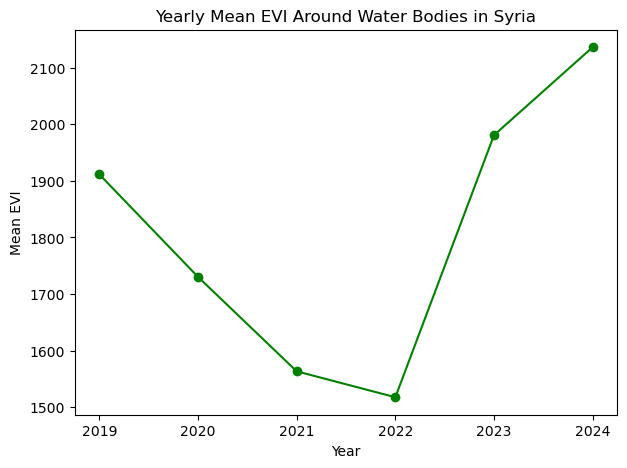

In [6]:
import pandas as pd

# Load the CSV file (assumed to have been loaded already in the previous step)
# evi_data = pd.read_csv('path/to/EVI_Time_Series_Buffer_Water_Bodies_Syria.csv')

# Convert the 'date' column to datetime format if not already done
evi_data['date'] = pd.to_datetime(evi_data['date'])

# Create a 'year' column based on the 'date' column
evi_data['year'] = evi_data['date'].dt.year

# Sort the data by year
evi_data.sort_values(by='year', inplace=True)

yearly_evi = evi_data.groupby('year')['mean_evi'].mean()

# Plot the yearly mean EVI
plt.figure(figsize=(7, 5))
plt.plot(yearly_evi.index, yearly_evi.values, marker='o', linestyle='-', color='green')
plt.title('Yearly Mean EVI Around Water Bodies in Syria')
plt.xlabel('Year')
plt.ylabel('Mean EVI')
plt.grid(False)
plt.show()


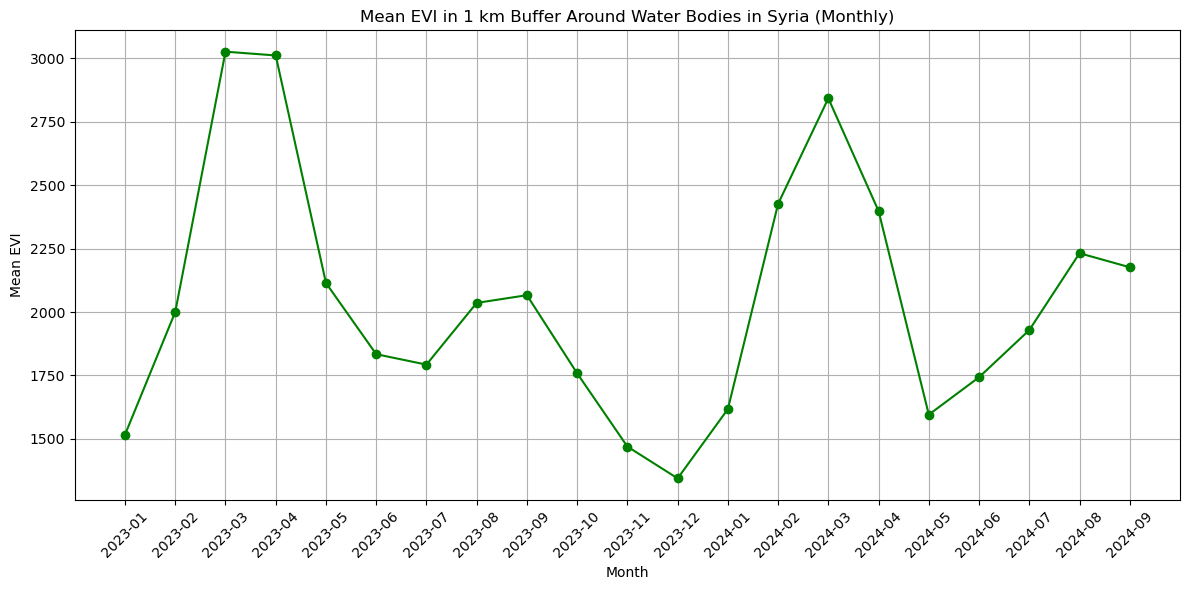

In [ ]:
#Convert the 'date' column to datetime format if not already done
evi_data_2022_2024 = evi_data[evi_data['year']>2022]

evi_data_2022_2024['date'] = pd.to_datetime(evi_data_2022_2024['date'])

# Create a 'month' column based on the 'date' column
evi_data_2022_2024['month'] = evi_data_2022_2024['date'].dt.to_period('4M')  # This will group by year-month

# Group by month and calculate the mean EVI for each month
monthly_evi = evi_data_2022_2024.groupby('month')['mean_evi'].mean()

# Plot the monthly mean EVI
plt.figure(figsize=(12, 6))
plt.plot(monthly_evi.index.astype(str), monthly_evi.values, marker='o', linestyle='-', color='green')
plt.title('Mean EVI in 1 km Buffer Around Water Bodies in Syria (Monthly)')
plt.xlabel('Month')
plt.ylabel('Mean EVI')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
'''import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'date' column to datetime format if not already done
evi_data['date'] = pd.to_datetime(evi_data['date'])

# Create 'year' and 'month' columns based on the 'date' column
evi_data['year'] = evi_data['date'].dt.year
evi_data['month'] = evi_data['date'].dt.month

# Group by year and month, then calculate the mean EVI for each month of each year
monthly_evi_per_year = evi_data.groupby(['year', 'month'])['mean_evi'].mean().reset_index()

# Loop through each year and create a separate plot
unique_years = monthly_evi_per_year['year'].unique()

for year in unique_years:
    # Filter data for the current year
    yearly_data = monthly_evi_per_year[monthly_evi_per_year['year'] == year]
    
    # Plot the monthly mean EVI for the current year
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_data['month'], yearly_data['mean_evi'], marker='o', linestyle='-', color='green')
    plt.title(f'Mean Monthly EVI for {year} in 1 km Buffer Around Water Bodies in Syria')
    plt.xlabel('Month')
    plt.ylabel('Mean EVI')
    plt.xticks(range(1, 13))  # Set x-ticks to represent months from 1 to 12
    plt.grid(True)
    plt.tight_layout()
    plt.show()'''


"import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Convert the 'date' column to datetime format if not already done\nevi_data['date'] = pd.to_datetime(evi_data['date'])\n\n# Create 'year' and 'month' columns based on the 'date' column\nevi_data['year'] = evi_data['date'].dt.year\nevi_data['month'] = evi_data['date'].dt.month\n\n# Group by year and month, then calculate the mean EVI for each month of each year\nmonthly_evi_per_year = evi_data.groupby(['year', 'month'])['mean_evi'].mean().reset_index()\n\n# Loop through each year and create a separate plot\nunique_years = monthly_evi_per_year['year'].unique()\n\nfor year in unique_years:\n    # Filter data for the current year\n    yearly_data = monthly_evi_per_year[monthly_evi_per_year['year'] == year]\n    \n    # Plot the monthly mean EVI for the current year\n    plt.figure(figsize=(10, 5))\n    plt.plot(yearly_data['month'], yearly_data['mean_evi'], marker='o', linestyle='-', color='green')\n    plt.title(f'Mean Monthly EVI 

In [ ]:
import sys
sys.path.append('C:/Users/ishaa/OneDrive/Desktop/DataLab/Syria/syria-economic-monitor/GEE_Zonal/src/gee_zonal')  # Replace with the actual path to the GEE_Zonal repository
import gee_helpers
from gee_helpers import gpd_to_gee

In [ ]:
import geopandas as gpd

# Load the water bodies shapefile
water_bodies_syria_gdf= gpd.read_file('C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\data\\clipped_syria_water.shp')

# Load the admin1 regions shapefile
adm = "ADM1"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm1_syr = gpd.read_file(res["gjDownloadURL"])

aoi1 = gpd_to_gee(adm1_syr)



Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM1/geoBoundaries-SYR-ADM1.geojson


In [ ]:
water_bodies_syria_gdf = water_bodies_syria_gdf.to_crs(adm1_syr.crs)

In [ ]:
# Perform a spatial join to find intersecting admin1 regions
admin1_within_buffer = gpd.sjoin(adm1_syr, water_bodies_buffer, how="inner", predicate="within")

# Remove duplicates if needed (in case multiple water bodies overlap the same admin1 region)
admin1_within_buffer = admin1_within_buffer.drop_duplicates(subset="shapeName")  # Replace with your admin1 identifier column name


In [ ]:
import numpy as np
from shapely.geometry import Point

# Step 1: Load the Admin1 and Water Bodies Shapefiles
admin1 = gpd.read_file(os.path.join(base_path,'data','boundaries','syr_admin1.shp'))
water_bodies = gpd.read_file(os.path.join(base_path,'data','clipped_syria_water.shp'))

# Step 2: Reproject to a Metric CRS
admin1 = admin1.to_crs(epsg=32637)  # UTM Zone for Syria
water_bodies = water_bodies.to_crs(epsg=32637)

# Step 3: Clip Water Bodies to Admin1 Boundaries (Optional)
water_bodies = gpd.clip(water_bodies, admin1)

# Step 4: Create 1 km Buffer Around Water Bodies
water_bodies['buffer_1km'] = water_bodies.geometry.buffer(5000)

# Step 5: Create a Regular Grid of Points
# Get the bounding box of the admin1 region or the buffer
minx, miny, maxx, maxy = admin1.total_bounds

# Define the resolution of the grid (e.g., 500m spacing)
resolution = 500  # 500 meters

# Generate points in a regular grid
x_coords = np.arange(minx, maxx, resolution)
y_coords = np.arange(miny, maxy, resolution)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]

# Create a GeoDataFrame for the grid points
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=admin1.crs)

# Step 6: Filter Points Within the Buffer Zone
buffered_water = gpd.GeoDataFrame(water_bodies[['buffer_1km']], geometry='buffer_1km')
points_within_buffer = gpd.sjoin(grid_gdf, buffered_water, how='inner', predicate='intersects')


In [ ]:
'''points_near_Tiberas = points_within_buffer[points_within_buffer['index_right']==1]
points_near_Tiberas'''


,geometry,index_right
132,POINT (183238.791 3643571.331),1
133,POINT (183238.791 3644071.331),1
134,POINT (183238.791 3644571.331),1
135,POINT (183238.791 3645071.331),1
136,POINT (183238.791 3645571.331),1
...,...,...
9056,POINT (187238.791 3641571.331),1
10167,POINT (187738.791 3639071.331),1
10168,POINT (187738.791 3639571.331),1
10169,POINT (187738.791 3640071.331),1


In [ ]:
'''output_path = os.path.join(base_path,'data','points_water_buffer_5k.shp')

# Export the GeoDataFrame to a shapefile
points_within_buffer.to_file(output_path, driver='ESRI Shapefile')'''


In [ ]:
'''output_path = os.path.join(base_path,'data','points_Tiberas.shp')

# Export the GeoDataFrame to a shapefile
points_near_Tiberas.to_file(output_path, driver='ESRI Shapefile')'''


In [ ]:
import ee
import geemap
import geopandas as gpd
import json

# Initialize the Earth Engine API
ee.Initialize()

# Load the points shapefile
gdf_points = gpd.read_file(os.path.join(base_path,'data','points_water_buffer_5k.shp'))

# Ensure the CRS is WGS84 (EPSG:4326), required for Earth Engine
gdf_points = gdf_points.to_crs("EPSG:4326")

# Convert the GeoDataFrame to GeoJSON and parse it into a dictionary
geojson_points = json.loads(gdf_points.to_json())

# Convert the GeoJSON to an Earth Engine FeatureCollection
points = ee.FeatureCollection(geemap.geojson_to_ee(geojson_points))

# Define the Syria boundary (replace this with your actual boundary shapefile or FeatureCollection)
syria_boundary_shapefile = os.path.join(base_path,'data','boundaries','syr_admin0.shp') # Replace with your shapefile path
gdf_boundary = gpd.read_file(syria_boundary_shapefile)
gdf_boundary = gdf_boundary.to_crs("EPSG:4326")  # Ensure CRS is WGS84
geojson_boundary = json.loads(gdf_boundary.to_json())
syria_boundary = ee.FeatureCollection(geemap.geojson_to_ee(geojson_boundary))

# Load the JRC Global Surface Water dataset
water_mask = ee.Image("JRC/GSW1_3/GlobalSurfaceWater")

# Clip the water mask to the Syria boundary
clipped_water_mask = water_mask.clip(syria_boundary.geometry())

# Define the water occurrence threshold (e.g., >50% occurrence)
water_threshold = clipped_water_mask.select("occurrence").gte(50).selfMask()

# Get the geometry of areas that are not water
land_geometry = water_threshold.Not().geometry()

# Filter points outside the water
points_outside_water = points.filterBounds(land_geometry)

# Visualize on the map
Map = geemap.Map(center=[34.8021, 38.9968], zoom=7)  # Centered on Syria
Map.addLayer(points_outside_water, {"color": "brown"}, "Points Outside Water")
Map.addLayer(water_threshold, {"palette": "lightblue"}, "Water Areas")
Map


Map(center=[34.8021, 38.9968], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [ ]:
adm1_path = os.path.join(base_path,'data','boundaries','syr_admin1.shp')
syr_adm1 = gpd.read_file(adm1_path)

coords = aoi.centroid().coordinates().getInfo()
centx, centy = coords[0],coords[1]
map_center = [centy, centx]

growing_season = ee.Filter.calendarRange(1, 6, 'month')
gs_evi_2023 = mxd13q1.filterDate('2023-01-01', '2023-12-31').filter(growing_season).mean().clip(aoi)

In [ ]:
'''# Define the export task
export_task = ee.batch.Export.table.toDrive(
    collection=points_outside_water,
    description='Points_Outside_Water',
    folder='EarthEngineExports',  # Specify a folder in your Google Drive
    fileNamePrefix='points_outside_water',  # Desired file name
    fileFormat='SHP'  # Other options: CSV, KML, SHP
)

# Start the export task
export_task.start()

print("Export task started. Check your Google Drive for the results.")'''

Export task started. Check your Google Drive for the results.
